# Exercises on Clustering
We start by defining a function that load a dataset stored in a `csv` format. The dataset file has the following format:

* In the first row there are the *number of samples* and the *number of features
* In the second row there is a list of the *names of the features* (comma separated)
* The remaining lines contain an example per row, which is represented as a list of real numbers that represent feature values

We then use such function to load every dataset that will be used later.

In [2]:
%matplotlib inline
import csv
import sys
from os.path import join
import numpy as np
 
# Load a dataset specified in a .csv format
# The first row should contain the number of samples and the number of features
# THe second row sould contain the feature names
def load_data(file_path, file_name):
    with open(join(file_path, file_name)) as csv_file:
        data_file = csv.reader(csv_file,delimiter=',')
        # Take the first row, which contains n_samples and n_features
        header = next(data_file)
        n_samples = int(header[0])
        n_features = int(header[1])
        # Now take the second row, which contains feature names
        header = next(data_file)
        feature_names = np.array(header[:n_features])
        # Take the rest of the data and store it in an array
        data_list = [iter for iter in data_file]
        data = np.asarray(data_list, dtype=np.float64)                  
    return (data,feature_names,n_samples,n_features)

# Directory on which the files are stored
file_path="./datasets/"
# All the three datasets contain data points on (x,y) 
file_name1="3-clusters.csv"
file_name2="dataset-DBSCAN.csv"     
file_name3="CURE-complete.csv"    
# Load the datasets
data1, feature_names1, n_samples1, n_features1 = load_data(file_path, file_name1)
data2, feature_names2, n_samples2, n_features2 = load_data(file_path, file_name2)
data3, feature_names3, n_samples3, n_features3 = load_data(file_path, file_name3)

Since every dataset on which we are working is a 2D dataset, can start by plotting them on a 2D space. In this way we can visualize them so that we can better interpret the results later.

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title(file_name1)

ax.set_xlabel(feature_names1[0])
ax.set_ylabel(feature_names1[1])

#plot the dataset
plt.plot(data1[:,0], data1[:,1], '.',markersize=1)

plt.show()

In [ ]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title(file_name2)

ax.set_xlabel(feature_names2[0])
ax.set_ylabel(feature_names2[1])

#plot the dataset
plt.plot(data2[:,0], data2[:,1], '.', markersize=2)

plt.show()

The following is the program for plotting the dataset n.3

In [ ]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111)
fig.subplots_adjust(top=1)
ax.set_title(file_name3)

ax.set_xlabel(feature_names3[0])
ax.set_ylabel(feature_names3[1])

#plot the dataset
plt.plot(data3[:,0], data3[:,1], '.', markersize=1.2, markeredgecolor = 'blue')

plt.show()

In the following program we cluster the dataset n.1 with K-means. 
From the plot of dataset n.1 we see 3 separated clusters. Thus k=3. 

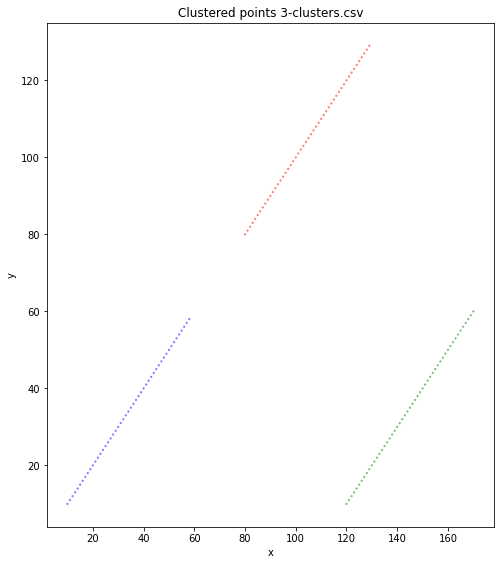

In [4]:
from sklearn.cluster import KMeans
# Setup seed for RNG
np.random.seed(5)
k=3
kmeans1 = KMeans(n_clusters=k, random_state=0).fit(data1)

# We also define a funcion to plot clusters in a given dataset
# This function also assume that x_values is a datasates rappresented only by 2 features (x and y)
def plot_clusters(x_values, y_values, n_samples, title = '', figsz = (8,8), point_sz = 5):
    import matplotlib.pyplot as plt
    # Plot formatting 
    fig = plt.figure(figsize=figsz)
    ax = fig.add_subplot(111)
    fig.subplots_adjust(top=1)
    ax.set_title('Clustered points ' + title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    # set the list of colors to be selected when plotting the different clusters
    color=['b','g','r','c','m','y','k','w']
        
    # Plot each cluster (by changing points color) in the dataset
    for clu in range(k):
        # collect the sequence of cooordinates of the points in each given cluster (determined by clu)
        data_list_x = [x_values[i,0] for i in range(n_samples) if y_values[i]==clu]
        data_list_y = [x_values[i,1] for i in range(n_samples) if y_values[i]==clu]
        plt.scatter(data_list_x, data_list_y, s=5, edgecolors='none', c=color[clu], alpha=0.5)
    plt.show()

plot_clusters(data1, kmeans1.labels_, n_samples1, file_name1)


As we can see, `KMeans` clustered correcly the datapoints of the first dataset

# Exercises
In the following cell I propose you to perform clustering with K-means on dataset2. How do you expect KMeans to perform?

In [ ]:
k=3
kmeans2 = KMeans(n_clusters=k, random_state=0).fit(data2)

# Plot the resulting clustered dataset
plot_clusters(data2, kmeans2.labels_, n_samples2, file_name2, figsz=(20,10))

As we we can see the results are in accordance with the theory: `KMeans` doesn't perform good on datasets with particularly-shaped clusters, like the ones on the dataset #2. This is because such clusters are not globular-shaped. `KMeans` will try to group them in globular shaped clusters anyway, with the result of giving an incorrect clustering.
For such types of clusters, it is reccomended to use `DBSCAN`, which we will use later on.


We are going to do the same thing with dataset #3, expecting to see something similar to happen.

In [ ]:
k=5
kmeans3 = KMeans(n_clusters=k, random_state=42).fit(data3)

# Plot the resulting clustered dataset
plot_clusters(data3, kmeans3.labels_, n_samples3, file_name3)

What it happens is that since `KMeans` focuses on optimizing cluster centers (*centroids*) it performs very badly on different size and density clusters.

In the following cells I propose you to write a program that computes with a statistical measure of your choice a quantitative evaluation of clusters in the three datasets.

**Note:**
It is advisable to execute K-means a certain number of times (let us try 10 times) and then select the clustering solution that gives the best value of the evaluation measure.

**Note to myself**: Since we need to run 10 times the inference algorithm for each dataset, I'm going to shrink the $3^{rd}$ dataset (which has about 8k datapoints) to a smaller version (about ~10% of its size)

In [ ]:
# In order to evaluate a clustering solution we are going to use the mean Silhouette score across all samples
from sklearn.metrics import silhouette_score

# Function to shrink a dataset 
def shrink_dataset(dataset, n_samples, rate):
    new_n_samples = int(rate * n_samples)
    indexes = np.random.choice(n_samples, new_n_samples, replace=False)
    return (dataset[indexes], new_n_samples)

# Shink the dataset (it's too big otherwhise it'll take too long to train the models)
data3, n_samples3 = shrink_dataset(data3, n_samples3, 0.1)

n_datasets = 3
n_runs = 10
datasets = np.array([data1, data2, data3], dtype=object)
seeds = np.random.randint(0, 100, n_runs)
clustered_data = []

# matrix to store results
scores = np.zeros((n_datasets, n_runs))

# For each model:
#  - infer a new clustering using Kmean
#  - save the corresponding score measure on the scores matrix
for ds in range(0, n_datasets):
    print("\nEvaluating Model " + str(ds))
    for i in range(0, n_runs):
        print("\n\tRunning evaluation " + str(i) + "...")
        # Cluster data using KMeans
        clustered = KMeans(n_clusters = k, random_state=seeds[i]).fit_predict(datasets[ds])
        # Compute silhouette score
        scores[ds, i] = silhouette_score(datasets[ds], clustered)


# TODO: Plot the scores on iterations (the best one it's just the maximum over the row)
print(scores)

As already done with classification by k-nn, plot in the cell below the quantitative measure of your choice (used above) with respect to an increasing value of k (the number of clusters) so that the best value of k can be selected.

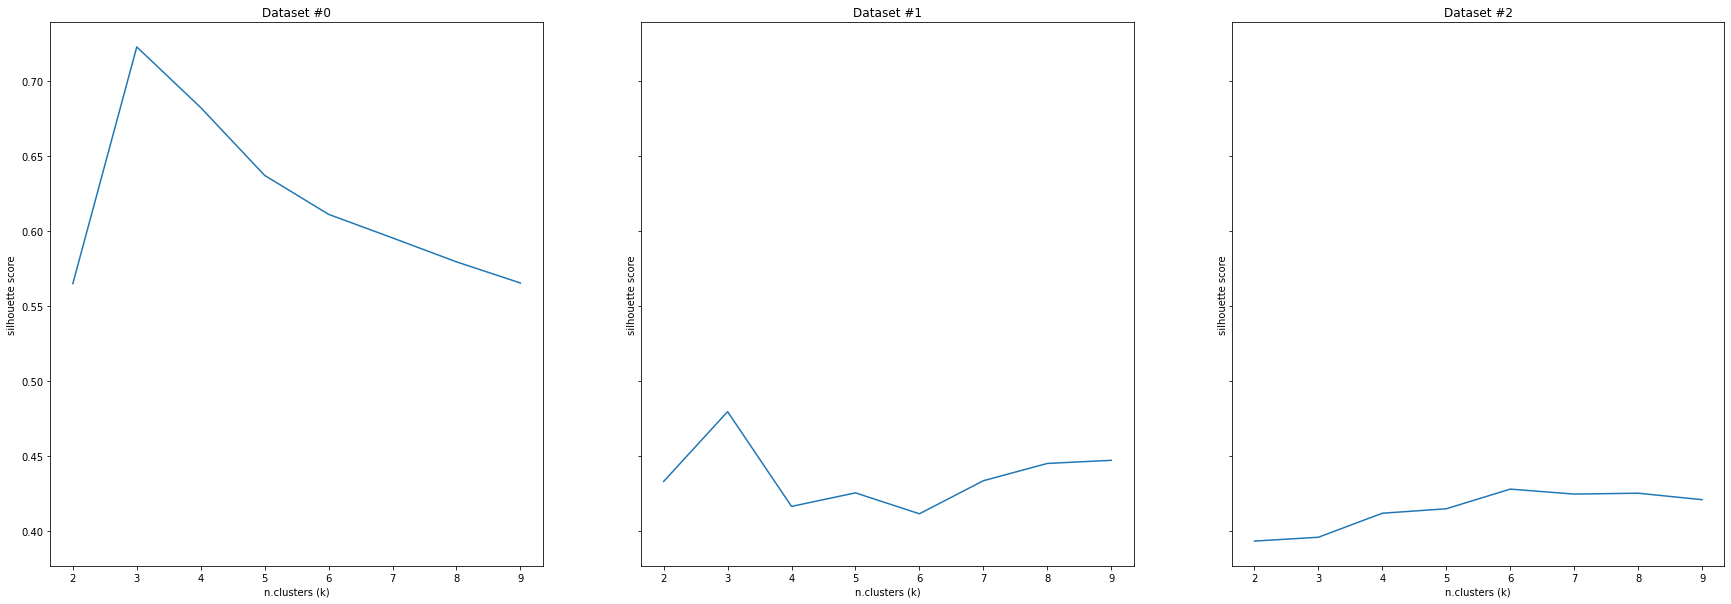

In [60]:
from sklearn.metrics import silhouette_samples

k_values = np.arange(2, 10)
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(30,10))

# Create a matrix to store scoring results
# Each row will store k scores of the ith classifier
scores = np.zeros((datasets.shape[0], k_values.shape[0]))

for i in range(0, n_datasets):
    for k in range(0, k_values.shape[0]):
        clustered = KMeans(n_clusters = k_values[k], random_state=0).fit_predict(datasets[i])
        ss = silhouette_score(datasets[i], clustered)
        scores[i, k] = ss
    axes[i].plot(k_values, scores[i,:])
    axes[i].set_ylabel('silhouette score')
    axes[i].set_xlabel('n.clusters (k)')
    axes[i].set_title('Dataset #' + str(i))

In the following cell I propose you to run DBSCAN, instead, on one of the last two datasets: either dataset2 or dataset3. 

At the beginning try using a pair of Minpts and Eps of your choice.

**Note:**
If the data is too big, **sample it random, using a factor of 0.1.**

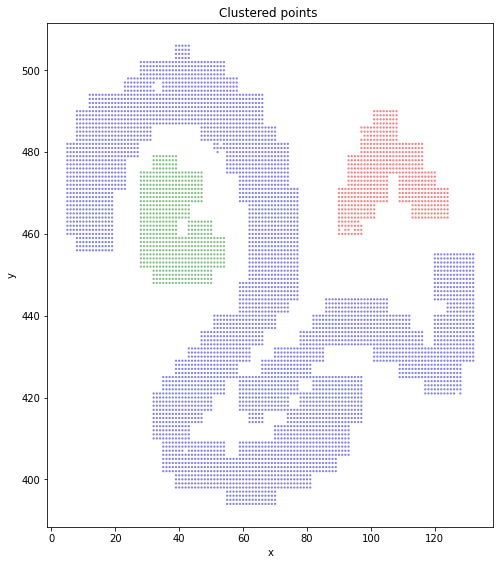

In [7]:
from sklearn.cluster import DBSCAN
min_pts = 3
eps = 1

# Run DBSCAN on the 2nd dataset
clusterer = DBSCAN(eps = eps, min_samples = min_pts).fit(data2)
plot_clusters(data2, clusterer.labels_, n_samples2)

In the following cell I propose you to: 

1.   Set *Minpts* to a number (say **10**).
2.   Compute the **reachability distance** of the **10-th nearest neighbour** for each data-point.
3. Sort the set of reachability distances you obtained in an increasing way.
4. Plot the sorted reachability distances
5. Find the **elbow** of the diagram => it gives the eps value combined with Minpts=10.
6. Try this combined pair of parameters on the dataset you chose, with DBSCAN.

In [66]:

# Import NearestNeighbors to compute nearest neighbours of datapoints
from sklearn.neighbors import NearestNeighbors

min_pts = 10
eps_step = 0.1
eps = 0

neigh = NearestNeighbors(n_neighbors=n_neighbors).fit(data2)

f = lambda x: x.shape[0]

# TODO: Not finished
for i in range(0, 30):
    nbrs = neigh.radius_neighbors(data2, radius=eps)
    nbrs_nr = np.array(list(map(f, nbrs[1])))
    density = sum(nbrs_nr >= min_pts)
    eps = eps + eps_step
    print(str(eps) + ": " + str(density))

0.1: 0
0.2: 0
0.30000000000000004: 0
0.4: 0
0.5: 0
0.6: 0
0.7: 0
0.7999999999999999: 0
0.8999999999999999: 0
0.9999999999999999: 0
1.0999999999999999: 0
1.2: 0
1.3: 0
1.4000000000000001: 0
1.5000000000000002: 0
1.6000000000000003: 0
1.7000000000000004: 0
1.8000000000000005: 0
1.9000000000000006: 0
2.0000000000000004: 0
2.1000000000000005: 5185
2.2000000000000006: 5185
2.3000000000000007: 5185
2.400000000000001: 6019
2.500000000000001: 6019
2.600000000000001: 6019
2.700000000000001: 6019
2.800000000000001: 6019
2.9000000000000012: 6019
3.0000000000000013: 6019
